# Human Activity Recognition



1. [Introduction](#Introduction)
2. [Data exploration](#Data-exploration)
3. [Reproducing the paper's results](#Reproducing-the-paper's-results)
4. [Feature generation](#Feature-generation)
5. [Naive Bayes](#Naive-Bayes)
6. [Logistic regression](#Logistic-regression)
7. [Decision trees](#Decision-trees)
8. [K-nearest neighbours](#K-nearest-neighbours)
9. [Feedforward neural network](#Feedforward-neural-network)
10. [Convolutional neural network](#Convolutional-neural-network)
11. [Conclusion](#Conclusion)

## Introduction

Smartphones, smartwatches and other mobile technology identify their orientation in space through the use of accelerometers. This information can be used, for example, to align the screen depending on the direction the device is held. 

The data collected by an accelerometer can also be used to identify the activity that a user is performing, such as jogging or sitting. In this project I use accelerometer records from the WISDM (Wireless Sensor Data Mining) [dataset](http://www.cis.fordham.edu/wisdm/dataset.php) to classify different daily activities.

The dataset contains accelerometer data from a group of people as they perform the following activities: walking, jogging, ascending stairs, descending stairs, sitting and standing. They carried a smartphone in their front trousers pocket while performing these activities for certain periods of time. Acceleration in all three spatial dimensions was recorded twenty times per second. More details on this dataset can be found on the original [paper](http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf).

In the following section we explore the data, fill missing values and visualize some features. Afther that I reproduce the original paper's results and develop my own fetaures to use in various learning algorithms.

## Data exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.io import arff
import matplotlib.pyplot as plt
%matplotlib inline
colours=['#F15152','#5F7FAB','#329F5B','#486C9F','#315A93','#1A4887','#04367C']

I start by loading the raw WISDM dataset.

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
raw = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [3]:
raw.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


The z-axis column is not in the right format. Next I remove the semicolon and convert the values to float numbers.

In [5]:
raw['z-axis'] = raw['z-axis'].str.replace(';', '').astype(float)

Now I check if there are any missing values in the dataset.

In [6]:
raw.isna().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

There is only one missing value, which can be safely removed.

In [7]:
raw.dropna(inplace=True)

Let's visualise the amount of readings for each activity:

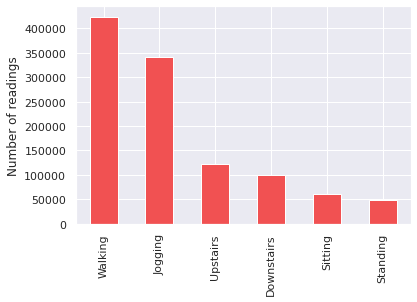

In [8]:
raw['activity'].value_counts().plot(kind='bar', color=colours[0])
plt.ylabel('Number of readings');

There is more data for walking and jogging. This imbalance can potentially affect the performance of the learning algorithms.

The next plot shows the distribution of data recorded amongst users.

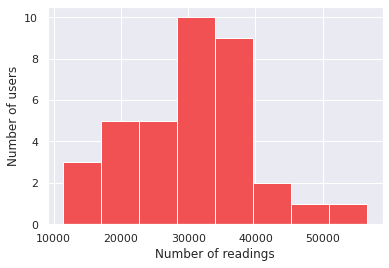

In [9]:
raw['user'].value_counts().hist(bins=8, color=colours[0])
plt.xlabel('Number of readings')
plt.ylabel('Number of users');

Now I plot some examples for each activity to see how different they look like.

In [10]:
def plot_example(activity, df, start=200, end=400):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][start:end].reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(data['x-axis'],color=colours[0], label='x-axis')
    ax.plot(data['y-axis'],color=colours[1], label='y-axis')
    ax.plot(data['z-axis'],color=colours[2], label='z-axis')
    ax.set_title(activity, fontsize=15)
    ax.set_xlabel('Reading number')
    ax.set_ylabel('Acceleration [m/s$^2$]')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

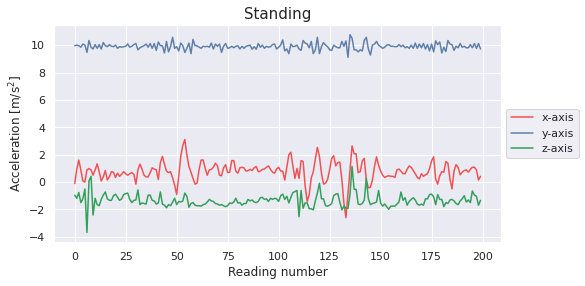

In [11]:
plot_example('Standing', raw)

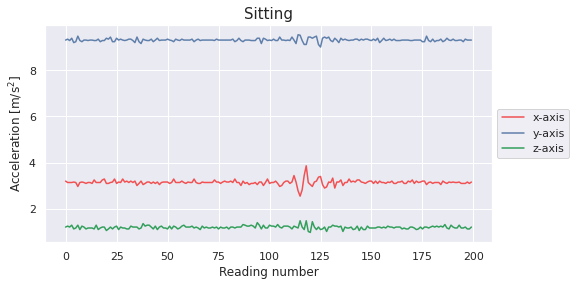

In [12]:
plot_example('Sitting', raw)

For standing and sitting, the sensors are stable and there is no periodic behaviour.

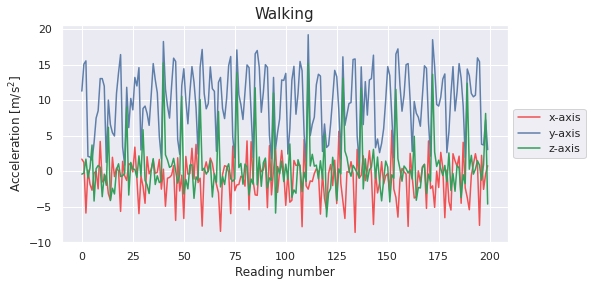

In [13]:
plot_example('Walking', raw)

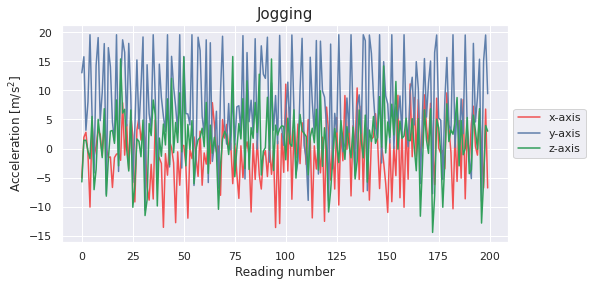

In [14]:
plot_example('Jogging', raw)

Walking and jogging show periodic patterns, with jogging having a higher frequency.

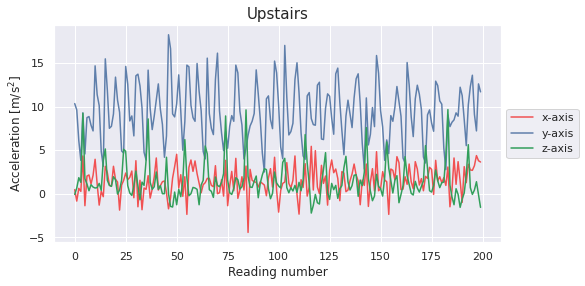

In [15]:
plot_example('Upstairs', raw)

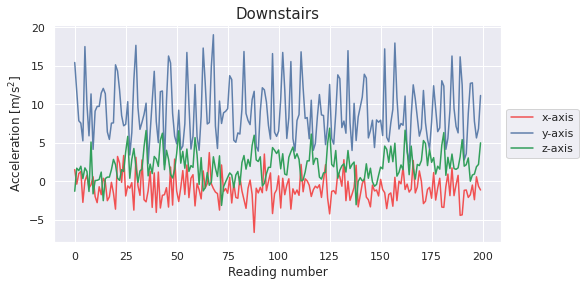

In [16]:
plot_example('Downstairs', raw)

Ascending and descending stairs also present periodic patterns. At least visually it seems difficult to distinguish between walking, going upstairs and going downstairs.

Now let's see what the whole data for sitting looks like:

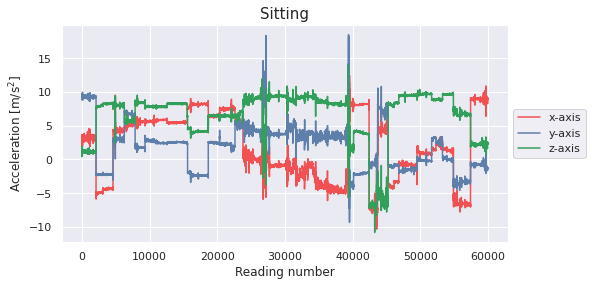

In [17]:
plot_example('Sitting', raw, start=0, end=None)

Even for a simple activity such as sitting there are different patterns for different users.

In the original paper, this raw data was divided into 10-second segments (200 readings). For each segment, different features were generated. Here is the transformed dataset:

In [18]:
data = arff.loadarff('data/WISDM_ar_v1.1_transformed.arff')
trans = pd.DataFrame(data[0]).sample(frac=1)
trans.head()

,UNIQUE_ID,user,X0,X1,X2,X3,X4,X5,X6,X7,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,class
3762,202.0,b'8',0.17,0.06,0.09,0.10,0.12,0.19,0.09,0.09,...,1466.67,1866.67,2.55,3.89,3.19,3.22,4.64,3.22,10.97,b'Walking'
1681,291.0,b'11',0.04,0.15,0.22,0.18,0.21,0.15,0.06,0.02,...,2483.33,2225.00,2.12,3.32,2.88,2.82,3.95,2.82,10.98,b'Walking'
4120,560.0,b'31',0.09,0.20,0.00,0.35,0.00,0.29,0.05,0.03,...,NaN,223.26,0.84,0.02,0.02,0.85,0.03,0.85,9.74,b'Sitting'
58,59.0,b'17',0.05,0.09,0.13,0.09,0.10,0.09,0.13,0.11,...,1900.00,1500.00,2.96,2.66,1.79,3.51,3.22,3.51,10.46,b'Walking'
950,288.0,b'27',0.12,0.09,0.14,0.12,0.10,0.09,0.07,0.08,...,567.65,3225.00,3.54,4.98,2.48,4.54,5.73,4.54,11.40,b'Walking'


In [19]:
trans['user'] = trans['user'].apply(lambda x: x.decode("utf-8"))
trans['class'] = trans['class'].apply(lambda x: x.decode("utf-8"))

Again I check if there are any missing values.

In [20]:
trans.isna().sum()[trans.isna().sum()>0]

XPEAK    381
YPEAK    131
ZPEAK    103
dtype: int64

I substitute the missing values with the average values of their respective columns. 

In [21]:
trans.fillna(trans.mean(), inplace=True)

Let's see an example of what the transformed data looks like.

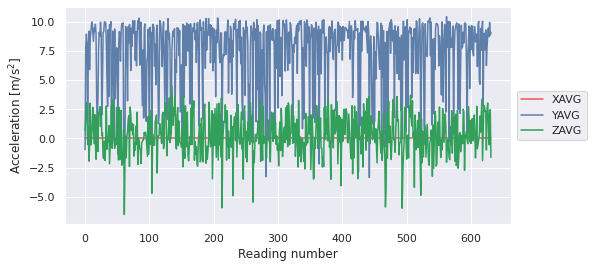

In [22]:
data = trans[trans['class'] == 'Upstairs'][['XAVG', 'YAVG', 'ZAVG']].reset_index()
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(data['XAVG'],color=colours[0], label='XAVG')
ax.plot(data['YAVG'],color=colours[1], label='YAVG')
ax.plot(data['ZAVG'],color=colours[2], label='ZAVG')
ax.set_xlabel('Reading number')
ax.set_ylabel('Acceleration [m/s$^2$]')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

There seems to be a problem with this transformed dataset as the average value for the x-axis is zero for every example.

In [23]:
trans['XAVG'].unique()

array([0.])

## Reproducing the paper's results

Ignoring this problem with their transformed data, I try to reproduce their results for logistic regression and decision trees models.  The paper's results obtained using ten-fold cross validation were:

- **Logistic regression**: overall accuracy of 78.1%.
- **Decision tree**: overall accuracy of 85.1%

In [24]:
X = trans.drop(['UNIQUE_ID','user','class'],axis=1)
y = trans['class']

X[X.columns] = StandardScaler().fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [25]:
lr = LogisticRegression(max_iter=5000)

lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

In [26]:
scores = cross_val_score(lr, X, y, cv=10)
print('Logistic regression: overall accuracy of (%0.f +/- %0.f)%%.' % (scores.mean()*100, 2*scores.std()*100))

Logistic regression: overall accuracy of (79 +/- 2)%.


In [27]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

In [28]:
scores = cross_val_score(dtree, X, y, cv=10)
print('Decisition tree: overall accuracy of (%0.f +/- %0.f)%%.' % (scores.mean()*100, 2*scores.std()*100))

Decisition tree: overall accuracy of (84 +/- 4)%.


Even with a problem in one of the transformed dataset's columns, their results were reproduced. 

## Feature generation

Here I generate features to be used in the learning algorithms from the raw dataset. The data is divided in groups of 200 raw accelerometer readings containing values corresponding to the three axes. Then the following features are calculated:

- Mean acceleration for each axis.
- Standard deviation for each axis.
- Correlation beatween the axes.
- Average of the resultant acceleration $\sqrt{a_x^2+a_y^2+a_z^2}$.
- Standard deviation of the resultant acceleration.

In [29]:
df = pd.DataFrame(columns=['user','x_mean','x_std','y_mean','y_std','z_mean','z_std','xy','xz','yz',
                                 'a_mean','a_std','activity'])

In [30]:
unique_id = 0
for user in raw['user'].unique():
    for activity in raw['activity'].unique():
        data = raw[(raw['user']==user) & (raw['activity']==activity)].reset_index()
        num = data.shape[0]//200
        for i in range(num):
            df.loc[unique_id, 'user'] = user
            df.loc[unique_id, 'activity'] = activity
            temp_x = data['x-axis'][i*200:(i+1)*200]
            temp_y = data['y-axis'][i*200:(i+1)*200]
            temp_z = data['z-axis'][i*200:(i+1)*200]
            df.loc[unique_id, 'x_mean'] = temp_x.mean()
            df.loc[unique_id, 'x_std'] = temp_x.std()
            df.loc[unique_id, 'y_mean'] = temp_y.mean()
            df.loc[unique_id, 'y_std'] = temp_y.std()
            df.loc[unique_id, 'z_mean'] = temp_z.mean()
            df.loc[unique_id, 'z_std'] = temp_z.std()
            df.loc[unique_id, 'xy'] = np.correlate(temp_x,temp_y)[0]
            df.loc[unique_id, 'xz'] = np.correlate(temp_x,temp_z)[0]
            df.loc[unique_id, 'yz'] = np.correlate(temp_y,temp_z)[0]
            acceleration = np.sqrt(np.square(temp_x)+np.square(temp_y)+np.square(temp_z))
            df.loc[unique_id, 'a_mean'] = acceleration.mean()
            df.loc[unique_id, 'a_std'] = acceleration.std()
            unique_id += 1

In [31]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,user,x_mean,x_std,y_mean,y_std,z_mean,z_std,xy,xz,yz,a_mean,a_std,activity
0,26,-6.72695,10.0439,3.19295,6.89769,-0.41265,7.75545,-1592.59,1036.79,-2367.74,15.1691,5.76565,Jogging
1,34,4.07505,7.67505,8.9366,9.11008,-0.4862,4.99933,10871.3,1435.9,-3361.52,15.2495,5.51065,Jogging
2,20,5.14765,8.50172,5.5193,7.98575,0.0160039,3.84508,11925.5,1113.82,71.7539,11.4736,8.70515,Jogging
3,6,6.4561,0.0525222,2.4854,0.0405222,6.49035,0.0367167,3209.27,8380.39,3226.17,9.48615,0.0410099,Sitting
4,14,-1.51555,3.5125,10.1819,3.53402,-1.2809,4.05397,-2512.72,2271.71,-2017.91,11.5364,3.95636,Walking


There are no missing values:

In [32]:
df.isna().sum()

user        0
x_mean      0
x_std       0
y_mean      0
y_std       0
z_mean      0
z_std       0
xy          0
xz          0
yz          0
a_mean      0
a_std       0
activity    0
dtype: int64

This new dataset is scaled and split into training and test sets in a 0.7:0.3 ratio.

In [33]:
X = df.drop(['user','activity'],axis=1)
y = df['activity']

X[X.columns] = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Naive Bayes

I use a Gaussian Naive Bayes as a baseline model.

In [34]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)

I define a function to plot the normalised confusion matrix, which I'll use for every algorithm.

In [35]:
def plot_cm(y, y_test, predictions):
    labels = np.sort(y.unique())
    cm = confusion_matrix(y_test, predictions)
    cmn = cm/cm.sum(axis=0)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    return cmn

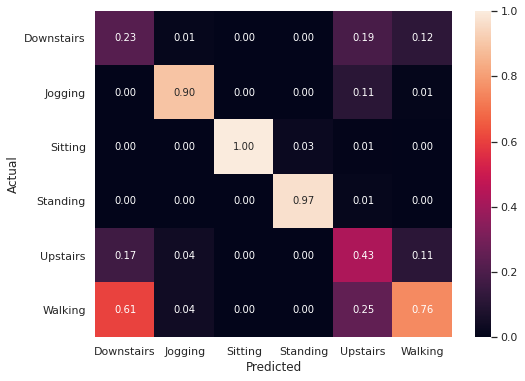

In [36]:
cmn_gnb = plot_cm(y, y_test, predictions)

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.23      0.26      0.24       150
     Jogging       0.90      0.96      0.93       489
     Sitting       1.00      0.96      0.98        78
    Standing       0.97      0.97      0.97        69
    Upstairs       0.43      0.32      0.36       184
     Walking       0.76      0.75      0.75       652

    accuracy                           0.74      1622
   macro avg       0.71      0.70      0.71      1622
weighted avg       0.73      0.74      0.73      1622



As expected the accuracy of this algorithm is not impressive. However it should be noted that it has done a good job classifying the sitting and standing activities, with not much confusion between them. It has perfomed poorly for the ascending and descending stairs activities, confusing them with other periodic activities such as walking.

The overall accuracy using ten-fold cross validation is:

In [38]:
scores_gnb = cross_val_score(gnb, X, y, cv=10)
print('Naive Bayes: overall accuracy of (%0.f +/- %0.f)%%.' % (scores_gnb.mean()*100, 2*scores_gnb.std()*100))

Naive Bayes: overall accuracy of (75 +/- 3)%.


## Logistic regression

Let's check how a logisitic regression model performs.

In [39]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

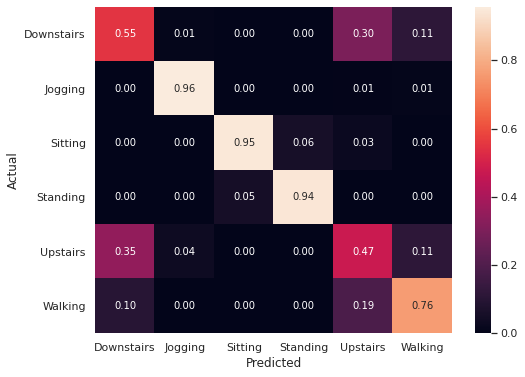

In [40]:
cmn_lr = plot_cm(y, y_test, predictions)

In [41]:
accuracy_lr = lr.score(X_test,y_test)

In [42]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.55      0.07      0.13       150
     Jogging       0.96      0.98      0.97       489
     Sitting       0.95      0.90      0.92        78
    Standing       0.94      0.94      0.94        69
    Upstairs       0.47      0.36      0.41       184
     Walking       0.76      0.96      0.85       652

    accuracy                           0.81      1622
   macro avg       0.77      0.70      0.70      1622
weighted avg       0.79      0.81      0.78      1622



Logistic regression performs a bit better than Naive Bayes.

The overall accuracy using ten-fold cross validation is:

In [43]:
scores_lr = cross_val_score(lr, X, y, cv=10)
print('Logistic regression: overall accuracy of (%0.f +/- %0.f)%%.' % (scores_lr.mean()*100, 2*scores_lr.std()*100))

Logistic regression: overall accuracy of (82 +/- 2)%.


## Decision trees

Now I'll try a decision tree model, which can capture non-linearities.

In [44]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

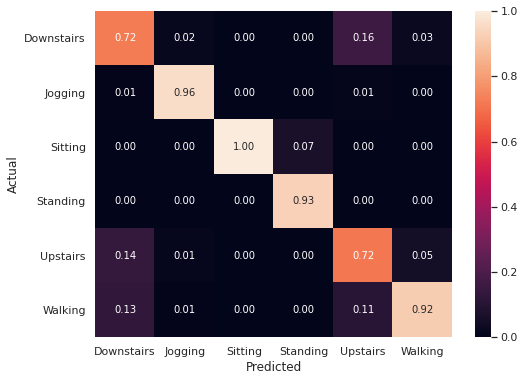

In [45]:
cmn_dtree = plot_cm(y, y_test, predictions)

In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.72      0.63      0.67       150
     Jogging       0.96      0.99      0.98       489
     Sitting       1.00      0.94      0.97        78
    Standing       0.93      1.00      0.97        69
    Upstairs       0.72      0.68      0.70       184
     Walking       0.92      0.94      0.93       652

    accuracy                           0.90      1622
   macro avg       0.88      0.86      0.87      1622
weighted avg       0.90      0.90      0.90      1622



This decision tree has done a better job at recognising the stairs activities.

The overall accuracy using ten-fold cross validation is:

In [47]:
scores_dtree = cross_val_score(dtree, X, y, cv=10)
print('Decision Tree: overall accuracy of (%0.f +/- %0.f)%%.' % (scores_dtree.mean()*100, 2*scores_dtree.std()*100))

Decision Tree: overall accuracy of (92 +/- 3)%.


This result can be improved using a random forest classifier.

In [48]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

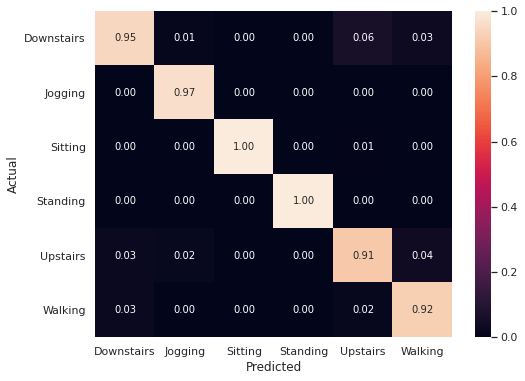

In [49]:
cmn_rfc = plot_cm(y, y_test, predictions)

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.95      0.74      0.83       150
     Jogging       0.97      1.00      0.98       489
     Sitting       1.00      0.99      0.99        78
    Standing       1.00      1.00      1.00        69
    Upstairs       0.91      0.77      0.83       184
     Walking       0.92      0.99      0.96       652

    accuracy                           0.95      1622
   macro avg       0.96      0.91      0.93      1622
weighted avg       0.94      0.95      0.94      1622



The overall accuracy using ten-fold cross validation is:

In [51]:
scores_rfc = cross_val_score(rfc, X, y, cv=10)
print('Random forest: overall accuracy of (%0.f +/- %0.f)%%.' % (scores_rfc.mean()*100, 2*scores_rfc.std()*100))

Random forest: overall accuracy of (95 +/- 2)%.


## K-nearest neighbours

Finally, before moving to neural networks, I use the k-nearest neighbours algorithm.

In [52]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

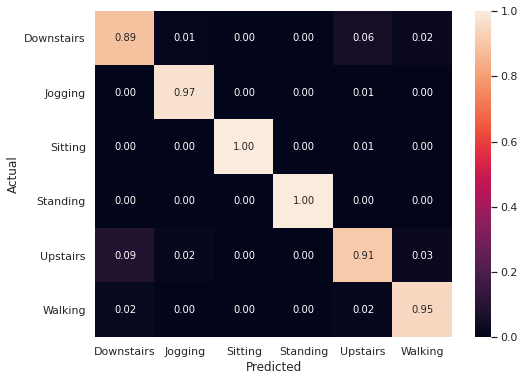

In [53]:
cmn_knn = plot_cm(y, y_test, predictions)

In [54]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.89      0.81      0.85       150
     Jogging       0.97      1.00      0.98       489
     Sitting       1.00      0.99      0.99        78
    Standing       1.00      1.00      1.00        69
    Upstairs       0.91      0.79      0.85       184
     Walking       0.95      0.99      0.97       652

    accuracy                           0.95      1622
   macro avg       0.95      0.93      0.94      1622
weighted avg       0.95      0.95      0.95      1622



The precision for the stairs activities is the highest so far.

The overall accuracy using ten-fold cross validation is:

In [55]:
scores_knn = cross_val_score(knn, X, y, cv=10)
print('KNN: overall accuracy of (%0.f +/- %0.f)%%.' % (scores_knn.mean()*100, 2*scores_knn.std()*100))

KNN: overall accuracy of (97 +/- 1)%.


## Feedforward neural network

Here the dataset is scaled and split into training, validation and test sets in a 0.7:0.15:0.15 ratio.

In [56]:
X = df.drop(['user','activity'],axis=1)
y = df['activity']

X[X.columns] = StandardScaler().fit_transform(X)

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

The labels are one-hot encoded:

In [57]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

Now I create the TensorFlow datasets:

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

The model is built with one densely connected hidden layer of 14 neurons.

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation=tf.nn.relu),
    tf.keras.layers.Dense(15, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

I use the adam optimiser and categorical cross entropy as the loss function.

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

The model is trained using batches of size 10.

In [61]:
BATCH_SIZE = 10
train_batch = train_dataset.cache().repeat().shuffle(X_train.shape[0]).batch(BATCH_SIZE)
val_batch = val_dataset.cache().repeat().shuffle(X_test.shape[0]).batch(BATCH_SIZE)
test_batch = test_dataset.cache().repeat().batch(BATCH_SIZE)

In [62]:
EPOCHS = 200

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(
    train_batch, epochs=EPOCHS, 
    steps_per_epoch=np.ceil(X_train.shape[0]/BATCH_SIZE),
    validation_data=val_batch, verbose=2, callbacks=early_stop,
    validation_steps=np.ceil(X_val.shape[0]/BATCH_SIZE))

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

379/379 - 1s - loss: 1.2038 - accuracy: 0.5770 - val_loss: 0.7510 - val_accuracy: 0.7598
Epoch 2/200
379/379 - 0s - loss: 0.6587 - accuracy: 0.7744 - val_loss: 0.5841 - val_accuracy: 0.7890
Epoch 3/200
379/379 - 0s - loss: 0.5336 - accuracy: 0.8063 - val_loss: 0.5262 - val_accuracy: 0.8232
Epoch 4/200
379/379 - 0s - loss: 0.4847 - accuracy: 0.8272 - val_loss: 0.4721 - val_accuracy: 0.8280
Epoch 5/200
379/379 - 0s - loss: 0.4957 - accuracy: 0.8140 - val_loss: 0.4532 - val_accuracy: 0.8378
Epo

The accuracies for both the training and validation are plotted below.

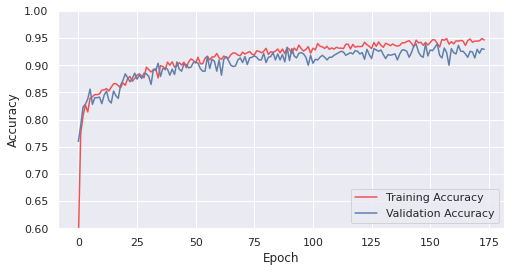

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs_range, acc, c=colours[0], label='Training Accuracy')
ax.plot(epochs_range, val_acc, c=colours[1], label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylim(0.6,1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch');

The accuracy on the training set is:

In [64]:
test_loss_fnn, test_accuracy_fnn = model.evaluate(test_batch, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
print('Feedforward neural network: overall accuracy of %0.1f%%.' % (100*test_accuracy_fnn))

82/82 [==============================] - 0s 1ms/step - loss: 0.2564 - accuracy: 0.9317
Feedforward neural network: overall accuracy of 93.2%.


The confusion matrix is plotted below.

In [65]:
predictions = model.predict(test_dataset.batch(1))

In [66]:
predictions_m = np.zeros((predictions.shape[0],6))
predictions_m[np.arange(predictions.shape[0]), predictions.argmax(1)] = 1 

In [67]:
cm = confusion_matrix(np.argmax(y_test.values,axis=1), np.argmax(predictions_m,axis=1))

Text(0.5, 30.5, 'Predicted')

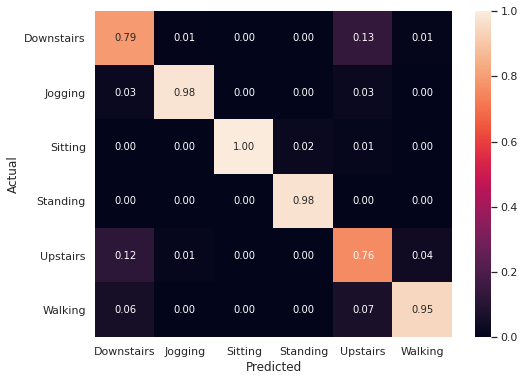

In [68]:
labels = np.sort(y.unique())
cmn_fnn = cm/cm.sum(axis=0)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_fnn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [69]:
print(classification_report(y_test,predictions_m))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        69
           1       0.98      0.99      0.98       281
           2       1.00      0.95      0.97        37
           3       0.98      1.00      0.99        40
           4       0.76      0.70      0.73        82
           5       0.95      0.97      0.96       302

   micro avg       0.93      0.93      0.93       811
   macro avg       0.91      0.90      0.90       811
weighted avg       0.93      0.93      0.93       811
 samples avg       0.93      0.93      0.93       811



## Convolutional neural network

The convolutional neural network is trained on the raw 10-second segments (200 readings).

In [70]:
segment_x = []
segment_y = []
segment_z = []
y = []
for user in raw['user'].unique():
    for activity in raw['activity'].unique():
        data = raw[(raw['user']==user) & (raw['activity']==activity)].reset_index()
        num = data.shape[0]//200
        for i in range(num):
            segment_x.append(data['x-axis'][i*200:(i+1)*200].values)
            segment_y.append(data['y-axis'][i*200:(i+1)*200].values)
            segment_z.append(data['z-axis'][i*200:(i+1)*200].values)
            y.append(activity)

In [71]:
segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_z = np.array(segment_z)

In [72]:
segment_x = StandardScaler().fit_transform(segment_x)
segment_y = StandardScaler().fit_transform(segment_y)
segment_z = StandardScaler().fit_transform(segment_z)

In [73]:
X = np.dstack((segment_x, segment_y, segment_z))
X.shape

(5406, 200, 3)

In [74]:
y = np.asarray(y)
y.shape

(5406,)

Here the dataset is split into training, validation and test sets.

In [75]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

The labels are one-hot encoded:

In [76]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

Now I create the TensorFlow datasets:

In [77]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

The model consists of two convolution blocks with a max pool layer in each of them. Before the final dense layers, there is a dropout probability of 0.5. Then there is a fully connected layer with 128 units. The model will output class probabilities for the six activities using softmax.

In [78]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation=tf.nn.relu, input_shape=(200, 3)),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(128, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [80]:
BATCH_SIZE = 10
train_batch = train_dataset.cache().repeat().shuffle(X_train.shape[0]).batch(BATCH_SIZE)
val_batch = val_dataset.cache().repeat().shuffle(X_test.shape[0]).batch(BATCH_SIZE)
test_batch = test_dataset.cache().repeat().batch(BATCH_SIZE)

In [81]:
EPOCHS = 20

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_batch, epochs=EPOCHS, 
    steps_per_epoch=np.ceil(X_train.shape[0]/BATCH_SIZE), callbacks=early_stop,
    validation_data=val_batch, verbose=2, validation_steps=np.ceil(X_val.shape[0]/BATCH_SIZE))

Epoch 1/20
379/379 - 6s - loss: 0.6084 - accuracy: 0.7757 - val_loss: 0.3831 - val_accuracy: 0.8671
Epoch 2/20
379/379 - 4s - loss: 0.3035 - accuracy: 0.8887 - val_loss: 0.2504 - val_accuracy: 0.9049
Epoch 3/20
379/379 - 4s - loss: 0.1787 - accuracy: 0.9396 - val_loss: 0.2200 - val_accuracy: 0.9232
Epoch 4/20
379/379 - 4s - loss: 0.1577 - accuracy: 0.9427 - val_loss: 0.2352 - val_accuracy: 0.9171
Epoch 5/20
379/379 - 4s - loss: 0.0913 - accuracy: 0.9712 - val_loss: 0.1670 - val_accuracy: 0.9366
Epoch 6/20
379/379 - 4s - loss: 0.0576 - accuracy: 0.9813 - val_loss: 0.2045 - val_accuracy: 0.9317
Epoch 7/20
379/379 - 4s - loss: 0.0779 - accuracy: 0.9747 - val_loss: 0.1715 - val_accuracy: 0.9341
Epoch 8/20
379/379 - 4s - loss: 0.0317 - accuracy: 0.9884 - val_loss: 0.2111 - val_accuracy: 0.9476
Epoch 9/20
379/379 - 4s - loss: 0.0634 - accuracy: 0.9781 - val_loss: 0.3622 - val_accuracy: 0.9134
Epoch 10/20
379/379 - 4s - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.1743 - val_accuracy: 0.9488

The accuracies for both the training and validation are plotted below.

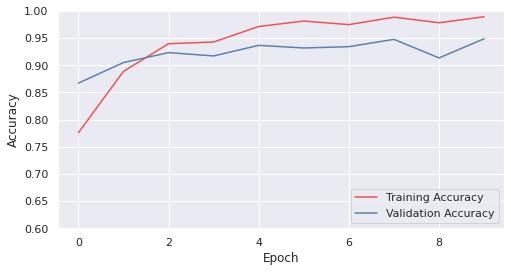

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs_range, acc, c=colours[0], label='Training Accuracy')
ax.plot(epochs_range, val_acc, c=colours[1], label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylim(0.6,1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch');

The accuracy on the training set is:

In [83]:
test_loss_cnn, test_accuracy_cnn = model.evaluate(test_batch, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
print('Feedforward neural network: overall accuracy of %0.1f%%.' % (100*test_accuracy_cnn))

82/82 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.9537
Feedforward neural network: overall accuracy of 95.4%.


The confusion matrix is plotted below.

In [84]:
predictions = model.predict(test_dataset.batch(1))

In [85]:
pred = np.zeros((predictions.shape[0],6))
pred[np.arange(predictions.shape[0]), predictions.argmax(1)] = 1 

In [86]:
cm = confusion_matrix(np.argmax(y_test.values,axis=1), np.argmax(pred,axis=1))

Text(0.5, 30.5, 'Predicted')

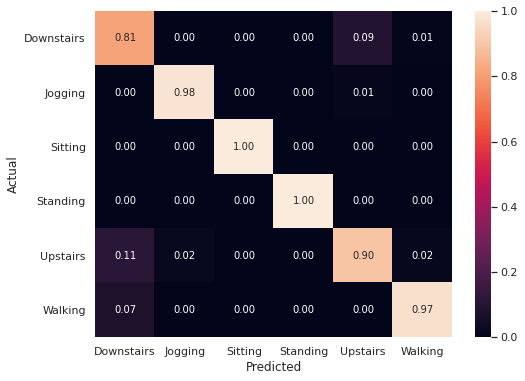

In [87]:
labels = np.sort(np.unique(y))
cmn_cnn = cm/cm.sum(axis=0)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_cnn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [88]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        75
           1       0.98      0.99      0.99       232
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        45
           4       0.90      0.78      0.83        89
           5       0.97      0.98      0.98       324

   micro avg       0.95      0.95      0.95       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.95      0.95      0.95       811
 samples avg       0.95      0.95      0.95       811



## Conclusion

The table below shows overall accuracy for each algorithm and their precision for the stairs activities (similar activities often confused with each other).

In [89]:
results = {'Overall accuracy (%)': [np.round(scores_gnb.mean(),3)*100,
                                np.round(scores_lr.mean(),3)*100,
                                np.round(scores_dtree.mean(),3)*100,
                                np.round(scores_rfc.mean(),3)*100,
                                np.round(scores_knn.mean(),3)*100,
                                np.round(test_accuracy_fnn,3)*100,
                                np.round(test_accuracy_cnn,3)*100],
           
           'Upstairs precision (%)': [np.round(cmn_gnb[0,0],3)*100,
                                  np.round(cmn_lr[0,0],3)*100,
                                  np.round(cmn_dtree[0,0],3)*100,
                                  np.round(cmn_rfc[0,0],3)*100,
                                  np.round(cmn_knn[0,0],3)*100,
                                  np.round(cmn_fnn[0,0],3)*100,
                                  np.round(cmn_cnn[0,0],3)*100],
           
           'Downstairs precision (%)': [np.round(cmn_gnb[4,4],3)*100,
                                  np.round(cmn_lr[4,4],3)*100,
                                  np.round(cmn_dtree[4,4],3)*100,
                                  np.round(cmn_rfc[4,4],3)*100,
                                  np.round(cmn_knn[4,4],3)*100,
                                  np.round(cmn_fnn[4,4],3)*100,
                                  np.round(cmn_cnn[4,4],3)*100],
        }

table = pd.DataFrame(results, columns = ['Overall accuracy (%)','Upstairs precision (%)','Downstairs precision (%)'], index=['Naive Bayes','Logistic regression', 'Decision tree', 'Random forest' ,'K-nearest neighbours', 'Feedforward neural network', 'Convolutional neural network'])
table

,Overall accuracy (%),Upstairs precision (%),Downstairs precision (%)
Naive Bayes,75.2,22.5,42.6
Logistic regression,81.8,55.0,47.5
Decision tree,91.9,72.3,71.8
Random forest,95.5,94.9,91.0
K-nearest neighbours,96.7,89.0,91.2
Feedforward neural network,93.2,79.4,76.0
Convolutional neural network,95.4,81.2,89.6


The random forest classifier and the convolutional neural network have performed best.